# Tutorial 2a: Managing data sets

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](http://bebi103.caltech.edu/2015/t2a_managing_data_sets.ipynb).*


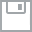
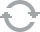
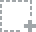
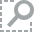
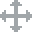
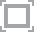
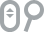
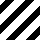
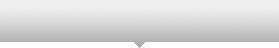
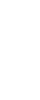
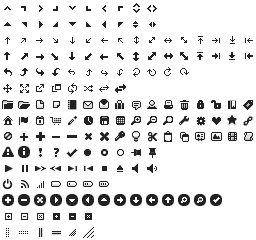
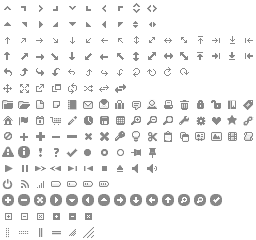
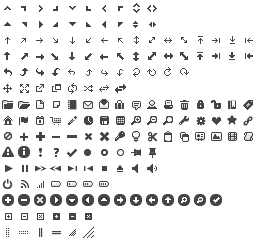
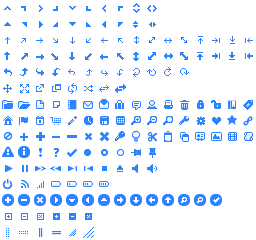
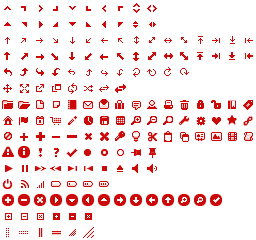
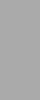
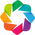
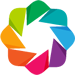

In [96]:
# Our numerical workhorses
import numpy as np
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# We'll use Pybeeswarm
import beeswarm as bs

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

In [Tutorial 1](http://bebi103.caltech.edu/2015/tutorials.html), we used data on frog tongue adhesion to learn about loading and plotting data.  That data set was relatively small and fairly easy to plot and investigate.  That is not to say it was trivial!

In this tutorial, we will work with a more complicated data set, which can be downloaded [here](http://bebi103.caltech.edu/2015/data/gandhi_et_al.zip).

The data we are investigating come from [David Prober](http://proberlab.caltech.edu/)'s lab.  A description of their work on the genetic regulation of sleep can be found on the [research page](http://www.proberlab.caltech.edu/Research.html) of the lab website.  There is a movie of the moving/sleeping larvae similar to the one used to produce the data set we are using in this tutorial.  The work based on this data set was published this past spring ([Gandhi et al., *Neuron*, **85**, 1193–1199, 2015](http://bebi103.caltech.edu/2015/protected/papers/gandhi_2015.pdf)).

In the experiment we are analyzing in this tutorial, we study the effect of a deletion  in the gene coding for arylalkylamine N-acetyltransferase (*aanat*), which is a key enzyme in the rhythmic production of melatonin.  Melatonin is a hormone responsible for regulation of circadian rhythms.  It is often taken as a drug to treat sleep disorders.  The goal of this study is to investigate the effects of aanat deletion on sleep pattern in 5+ day old zebrafish larvae.

In our data set, we have data on the movement of zebrafish larvae over time for wild type, heterozygous mutant, and homozygous mutant zebrafish.

To understand how the data were taken, here is the text of the Methods section of [Prober, et al., *J. Neurosci.*, **26**, 13400-13410, 2006](http://bebi103.caltech.edu/2014/protected/papers/prober_2006.pdf).
>Larvae were raised on a 14/10 h light/dark (LD) cycle at 28.5°C. On the fourth day of development, single larva were placed in each of 80 wells of a 96-well plate (7701-1651; Whatman, Clifton, NJ), which allowed simultaneous tracking of each larva and prevented the larvae from interfering with the activity of each other. Locomotor activity was monitored for several days using an automated video-tracking system (Videotrack; ViewPoint Life Sciences, Montreal, Quebec, Canada) with a Dinion one-third inch Monochrome camera (model LTC0385; Bosch, Fairport, NY) fitted with a fixed-angle megapixel lens (M5018-MP; Computar) and infrared filter, and the movement of each larva was recorded using Videotrack quantization mode. The 96-well plate and camera were housed inside a custom-modified Zebrabox (ViewPoint Life Sciences) that was continuously illuminated with infrared lights and was illuminated with white lights from 9:00 A.M. to 11:00 P.M. The 96-well plate was housed in a chamber filled with circulating water to maintain a constant temperature of 28.5°C. The Videotrack threshold parameters for detection were matched to visual observation of the locomotion of single larva. The Videotrack quantization parameters were set as follows: detection threshold, 40; burst (threshold for very large movement), 25; freeze (threshold for no movement), 4; bin size, 60 s. The data were further analyzed using custom PERL software and Visual Basic Macros for Microsoft (Seattle, WA) Excel. Any 1 min bin with zero detectable movement was considered 1 min of rest because this duration of inactivity was correlated with an increased arousal threshold; a rest bout was defined as a continuous string of rest minutes. Sleep latency was defined as the length of time from lights out to the start of the first rest bout. An active minute was defined as a 1 min bin with any detectable activity. An active bout was considered any continuous stretch of 1 min bins with detectable movement.

The data set comes exactly (except for the comments) as I received it from Avni Gandhi, the first author of the paper.  These are the raw data that come from the automated instrument/camera system (Videotrack) that measures the fish.  In this tutorial, you will parse these raw data into tidy `DataFrame`s and then save them as CSV files.  (In [Tutorial 2b](http://bebi103.caltech.edu/2014/protected/tutorials/t2b_defining_parameters_and_estimating_them.html), we will use these `DataFrame`s to define and estimate some parameters.)  This may seem like a mundane task, and maybe not very instructive, but this type of thing is encountered time and time again while doing real data analysis.  Hopefully in this tutorial, you will learn the tricks of the trade on simple ways to parse complicated data files that are not already in tidy format.  As a reminder, we are using ["tidy" as a technical term](http://bebi103.caltech.edu/2015/tutorials/t1b_exploratory_data_analysis.html#Tidy-data).

## Data file names

First, we need to unzip the data set using your favorite unzipper.  You will have two data files.  One is `130315_1A_genotypes.txt`, which specifies the genotype of the larva in each well.  The other is `130315_01_rawDATA.txt`, which contains (you guessed it) the raw data from each well, as well as the time points for acquisition.

I pause for a moment to comment that these are the file names that I received from the Prober lab.  Their method of naming their files is a good one, I think, and one that I use in my own research.  By naming first with a six-digit year-month-day code, they will appear in chronological order on your computer, which makes it easier to reference against your lab notebook.  Because these are long experiments, the time is not also included.  In cases where I do several experiments in a day, I use a 10-digit code, where the last four digits are the 24-hour-style time that the experiment was done.  The file name after the time-stamp code should contain a description of the experiment itself.

## The genotype data
We'll first load the genotype file.  Each column in this file contains a list of wells in the 96 well plate corresponding to each genotype.  Looking at this with a text editor reveals that it is a tab delimited file.  We can parse this using the `delimiter` keyword argument of `pd.read_csv`.  When specifying the delimiter, tabs are denoted as `\t`.

We also see that there are two header rows.  The first is really redundant, so we can skip it.  Nonetheless, we will read both in as headers using the `header` kwarg of `pd.read_csv()`.

In [97]:
# Load in the genotype file, call it df_gt for genotype DataFrame
fname = '../data/gandhi_et_al/130315_1A_genotypes.txt'
df_gt = pd.read_csv(fname, delimiter='\t', comment='#', header=[0, 1])

# Take a look at it (this only works in IPython/Jupyter)
df_gt

,Genotype1,Genotype2,Genotype3
,WT 17,Het 34,Mut 22
0,2,1,4
1,14,3,11
2,18,5,12
3,24,6,13
4,28,8,20
5,29,10,21
6,30,15,23
7,54,19,27
8,58,22,35


We notice that we have two header rows for the columns.  If we look at the column names, we see that they are a `MultiIndex` instance.  This is part of Pandas's slick multi-indexing functionality, which is not something we need if we have tidy data.  (However, messy data using multi-indexing may result in performance boosts for accessing data.  This may become important for very large data sets.  In general, tidy data are easier to conceptualize and syntactically much simpler to access.)

In [98]:
df_gt.columns

MultiIndex(levels=[['Genotype1', 'Genotype2', 'Genotype3'], ['Het 34', 'Mut 22', 'WT 17']],
           labels=[[0, 1, 2], [2, 0, 1]])

We do not need the multi-indexing, and level zero of indexing (`'Genotype1'`, etc.) is not necessary.  So, we just want level one index.  This is easily obtained using the `get_level_values()` method of Pandas `MultiIndex` objects.

In [99]:
# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

Index(['WT 17', 'Het 34', 'Mut 22'], dtype='object')

The numbers at the end of these column headings say how many of each type were encountered.  These are dispensable, so let's clean up the column names.

In [100]:
df_gt.columns = ['wt', 'het', 'mut']

Note that we could have done this in the first place instead of messing around with the `MultiIndex`, but I wanted you to be aware that multi-indexing is possible in Pandas and to recognize it when you encounter it.

### Tidying the genotype data
As they are, the data are not tidy.  For tidy data, we would have two columns, `'fish'`, which give the well number for each embryo, and `'genotype'`, which with either `'wt'` for wild type, `'het'` for heterozygote, or `'mut'` for mutant.  

A useful tool for tidying data is the `pd.melt()` function.  For this simple data set, it takes the column headings and makes them into a column (with repeated entries) and puts the data accordingly in the correct order.  We just need to specify the name of the "variable" column, in this case the genotype, and the name of the "value" column, in this case the fish ID.

In [101]:
# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='fish')

# Take a look
df_gt

,genotype,fish
0,wt,2
1,wt,14
2,wt,18
3,wt,24
4,wt,28
5,wt,29
6,wt,30
7,wt,54
8,wt,58
9,wt,61


The NaN entries were still preserved.  We can drop them using the `dropna()` method of `DataFrame`s.

In [102]:
# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

# Take a look
df_gt

,genotype,fish
0,wt,2
1,wt,14
2,wt,18
3,wt,24
4,wt,28
5,wt,29
6,wt,30
7,wt,54
8,wt,58
9,wt,61


We now have a tidy `DataFrame`.  Note, though, that the indices do have some skips.  This happened when we dropped the NaN's.  This is of no concern, since we will not use them.  If it annoys you, though, you can use the `reset_index()` method.

In [103]:
df_gt = df_gt.reset_index(drop=True)

## Initial cleaning of the raw activity data

Let's now load the raw data.  Again, but looking at the file in a text editor, we can see that it is tab delimited (and quite large) with two header rows.  As a reminder, each entry in this data set is the number of seconds in a one-minute interval during with the larva was moving.

In [311]:
# Load raw data into a DataFrame
fname = '../data/gandhi_et_al/130315_01_rawDATA.txt'
df = pd.read_csv(fname, delimiter='\t', comment='#', header=[0, 1])

# Take a look
df.head()

,TIME(SECONDS),Unnamed: 1_level_0,FISH1,FISH2,FISH3,FISH4,FISH5,FISH6,FISH7,FISH8,...,FISH90,FISH91,FISH92,FISH93,FISH94,FISH95,FISH96,Unnamed: 98_level_0,Unnamed: 99_level_0,CLOCK
,start,end,middur,middur,middur,middur,middur,middur,middur,middur,...,middur,middur,middur,middur,middur,middur,middur,Unnamed: 98_level_1,Unnamed: 99_level_1,Unnamed: 100_level_1
0,0,60,0.6,1.4,0,0.0,0.0,0,0,1.7,...,0.0,0,0.0,0,0.0,0,20.1,NaN,NaN,9.519
1,60,120,1.9,0.0,0,0.0,0.0,0,0,0.0,...,0.0,0,0.0,0,0.0,0,21.2,NaN,NaN,9.536
2,120,180,1.9,0.0,0,1.5,0.1,0,0,0.0,...,0.0,0,23.5,0,0.3,0,18.7,NaN,NaN,9.553
3,180,240,13.4,0.0,0,4.5,0.0,0,0,0.0,...,0.0,0,29.0,0,0.4,0,15.9,NaN,NaN,9.569
4,240,300,15.4,0.0,0,0.0,0.0,0,0,0.0,...,0.1,0,24.4,0,0.1,0,11.8,NaN,NaN,9.586


We see that we have over 5000 time points for each of 96 fish.  The file also contains some redundant headers and two blank columns.  Unfortunately, level 1 for the first two columns is appropriate for the column name and level 0 is appropriate for the remaining columns.  We can deal with this by explicitly taking the first two columns at level 1 and the remaining at level 0.

In [312]:
# Make list of columns (use type conversion to allow list concatenation)
df.columns = list(df.columns.get_level_values(1)[:2]) \
                            + list(df.columns.get_level_values(0)[2:])

Now, we wish to drop any column that has the string `'Unnamed'` in its name.  We can use Pandas's convenient `str` methods.  We can get a list of the columns we want to drop using the `str.contains()` method.

In [313]:
# Columns we want to drop
cols_to_drop = df.columns[df.columns.str.contains('Unnamed')]

Now, we can use the `drop()` method to drop them.

In [314]:
# Drop the columns (use axis=1 to drop columns, axis=0 to drop rows)
df = df.drop(cols_to_drop, axis=1)

The `start` and `end` times are dispensable because the stop point of one entry is the start point of the next.  We can therefore delete those columns.

In [315]:
df = df.drop(['start', 'end'], axis=1)

Finally, we note that the genotype of some of the fish is unknown.  To check, we need to convert entries like `'FISH42'` to just `42`.  This is easily done using Python's built-in string methods and type conversion.

In [316]:
int('FISH42'.lstrip('FISH'))

42

Now, we just loop through the `FISH` columns of the `DataFrame` and drop the once that do not have genotypes.

In [317]:
# Find columns to drop
cols_to_drop = []
for col in df.columns:
    if 'FISH' in col and int(col.lstrip('FISH')) not in df_gt['fish'].values:
            cols_to_drop.append(col)

# Drop 'em!
df = df.drop(cols_to_drop, axis=1)

We've now cleaned up the headers and gotten rid of the blank columns.  Time to tidy!

## Tidying time series data
In general, the best way to tidy time series data of multiple measurements is difficult to define.  For now, let's consider a simplified version of our data set were we just have a set of time points for each fish with an activity measured at each time point.  This is analogous to any generic time series for multiple measurements.

I can think of three options on how to tidy a generic set of time series data.
1. Each row represents a single fish at a single time interval.  For this data set, the columns are then `['fish', 'time', 'activity']`.
2. Each row represents a single time point, considering all fish.  For this data set, the columns are then `['time', 'activity_1', 'activity_2', ...]`, where the integers correspond to IDs of the fish we're studying.
3. Each row represents a single fish.  In this case, the columns are `['fish', t_0, t_1, t_2, ...]`, where `t_0`, `t_1`, etc., are the time points.  We could less ambiguously call these column headings `'activity_t_0'`, `'activity_t_1'`, etc.  We would also need to name our indices after the fish, with with a number or string.

One could make arguments for any of these.  Option 1 is obviously tidy: one observation, one row.  Option 2 could be considered tidy.  The 96-well plate is observed at each time point.  The data from each observation are the activities of every fish.  Similarly, Option 3 could also be tidy.  Each observation is the time course for an individual fish.  

Now, in our case, we also want need to include information about the genotype of each fish.  If we want to add these data, the column headings are adjusted as follows.
1. `['fish', 'genotype', 'time', 'activity']`.
2. `['time', 'activity_%s_1', 'activity_%s_2', ...]`, where the strings represent the genotype.
3. `['fish', 'genotype', t_0, t_1, ...]`.
For option 2, we could alternatively use a multi-index for the activities for a given fish ID and genotype.  If we did want to use the column headings with the strings describing genotype as shown above, we could use the `str` methods of `DataFrame`s to select which columns to use.

Now, we also want to incorporate convenient information about the time points, such as what day it is or if the light is on or not.  Adding this information, the new column headings are
1. `['fish', 'genotype', 'day', 'light', 'time', 'activity']`.
2. `['day', 'light', 'time', 'activity_%s_1', 'activity_%s_2', ...]`, where the strings are the genotype.
3. `['fish', 'genotype', '%s_%d_%f', ...]`, where the string formats represent `'light'` or `'dark'`, the day, and the time stamp.
Now it becomes clear that multi-indexing is useful for 2 and 3.  The headings get to be unruly and difficult to search.

It is also clear that if we want to include any information about the individual subjects or about time points that option 1 is the only one that can be kept tidy (and index-able using only column slicing and Boolean indexing).

So, for time series data, if we do not need any other information about the subjects (besides their IDs) nor about the time points (besides their values), tidying options 1, 2, and 3 are all reasonable.  I would argue that option 3 is in some cases a bit more difficult to work with because of the necessary labeling of indices and the use of the values in the column heading (the times) for plotting and analysis.  So, in my opinion, options 1 and 2 are preferred.

However, if other information about the subjects (such as genotype in this case) are needed, multi-indexing is required for option 2.  Option 1 always provides tidy data.

We will ultimately have a Zeitgeber time, as well as information giving the day and whether or not the light was on for a given time point.  (These latter two are for convenience.)  We also want to have the genotype of the fish being considered.

We will use option 1 in our analysis, but I will show how to tidy the data into the shapes of options 2 and 3 for demonstration purposes.

Before we tidy the data, however, we need to make sure everything is ok with the clocks!  The data, as loaded form the software, are ordered, and tidying will destroy the input ordering.  We therefore need to ensure that reordering the data will not result in the loss of any information.

## Setting the Zeitgeber time

When inspecting the `DataFrame` a little more closely, we see that the `CLOCK` times are not sequential.  This is most easily seen by plotting them.

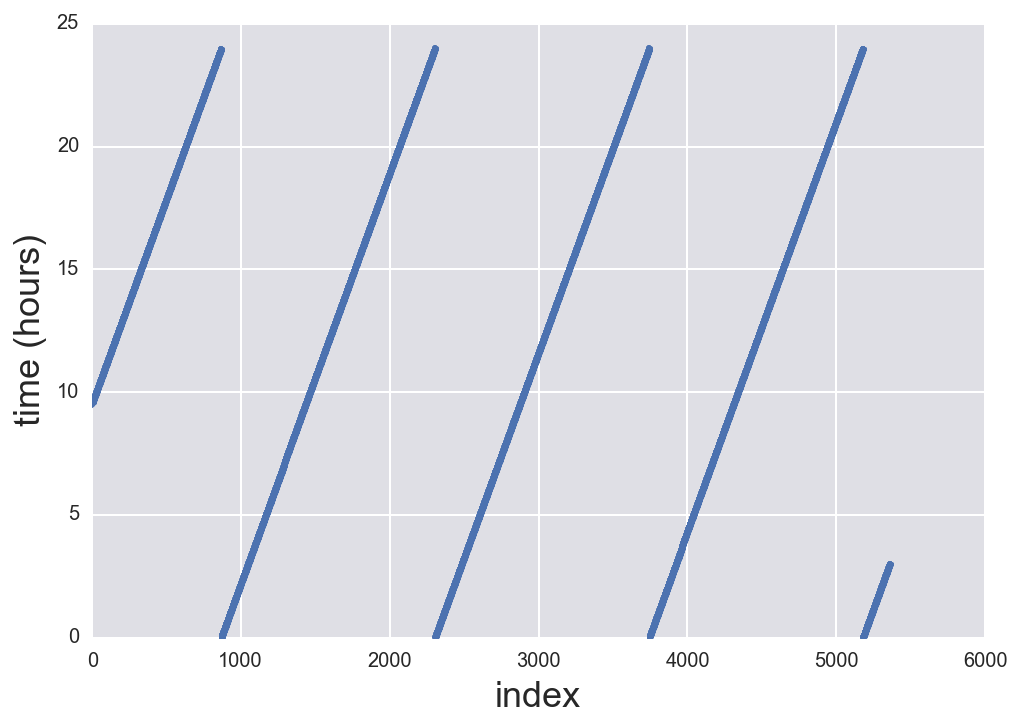

In [318]:
# Plot clock and t_start values
plt.plot(df.CLOCK, '.')
plt.xlabel('index')
plt.ylabel('time (hours)')

It would be better to have continuous time.  It is also convenient to work with so-called Zeitgeber time, where 0 corresponds to 9AM when the lights go on, and 14 hours corresponds to 11PM, when the lights go off.  We would therefore like to have continuous Zeitgeber time, meaning we go from the start of the experiment continuously though, such that 9h, 33h, etc., all correspond to Zeitgeber time zero.  As per the comments at the head of the data set, the `df.CLOCK` column gives the Zeitgeber time.

Before we do that, let's exploit the values in `df.CLOCK` to create a column containing Booleans as to whether the light is on.  We have to be careful when adding the `light` column to the `DataFrame`.  This is because it needs to have the indices as `df`.  To do this, we make the `light` column into a Pandas `Series`, which is basically a column of a `DataFrame`.  When we do this, we use the `index` keyword argument to set the indexing of the `Series` to match that of `df`.  We can then add the Series as a column to the `DataFrame`.

In [319]:
df['light'] = pd.Series(df.CLOCK < 14.0, index=df.index)

Computing which day it is is a bit more tricky.  Remeber, these are "days" according to the zeitgeber time, meaning that they go from 9AM to 9AM PST.  The experiment was started in the middle of day 0. We have to find when the light goes from off to on (that's the start of a day), and then populate every entry until the next time the light goes from off to on (the start of the next day) with the same index.  We can find where we switch from dark to light by using the `np.diff` function, which computes the difference between consecutive entries in an array.  Wherever we have `np.diff(df.light.astype(np.int))` equal to unity, we have switched from dark to light.  (Note that we have converted `df.light` from Boolean to integer, because `np.diff` treats differences as Booleans as Booleans, meaning that it returns `True` for transitions from day to night and from night to day.)  We can then use the `np.where` function to find where the switches took place.  Finally, we can loop through these point and populate the `day` array.

In [320]:
# Find where the lights switch from off to on. 
dark_to_light = np.where(np.diff(df.light.astype(np.int)) == 1)[0]

# Initialize array with day numbers
day = np.zeros_like(df.light, dtype=np.int)

# Loop through transitions to set days (+1 on indices b/c diff() is offset by 1)
for i in range(len(dark_to_light) - 1):
    day[dark_to_light[i]+1:dark_to_light[i+1]+1] = i + 1
day[dark_to_light[-1]+1:] = len(dark_to_light)

# Insert into DataFrame
df['day'] = pd.Series(day, index=df.index)

We now need to compute the continuous Zeitgeber time.  This is easily done using the `day` values we computed.  We will call the column with the continuous Zeitgeber time `zeit`.

In [321]:
# Build ziet
zeit = 24.0 * df.day + df.CLOCK

# Put in DataFrame
df['zeit'] = pd.Series(zeit, index=df.index)

We now have all the information in our `DataFrame` that we need.  We can proceed to tidy it.

## Tidying the `DataFrame`
As I mentioned before, we will tidy the data using all three of the aforementioned options.

### Tidying option 1
For this option, we again use the `pd.melt()` function.  It is easiest to incorporate the genotype by making a multi-index for the columns and then using `pd.melt()`.  We first get a list of genotypes for our respective fish from our tidy `df_gt`.

In [338]:
# Build list of genotypes
genotypes = []

# Check each column, put 'dummy' for non-FISH column
for col in df.columns:
    if 'FISH' in col:
        fish_id = int(col.lstrip('FISH'))
        genotypes.append(df_gt.genotype[df_gt.fish==fish_id].iloc[0])
    else:
        genotypes.append(None)

Now that we have the list of genotypes, we can make a multi-index with genotypes.  It's as simple as reassigning the columns to be a list of lists.

In [339]:
df.columns = [df.columns, genotypes]

TypeError: view() got an unexpected keyword argument 'name'

Now let's look at our multi-indexed `DataFrame`.

In [340]:
df.head()

,FISH1,FISH2,FISH3,FISH4,FISH5,FISH6,FISH8,FISH10,FISH11,FISH12,...,FISH89,FISH90,FISH92,FISH93,FISH95,FISH96,CLOCK,light,day,zeit
,het,wt,het,mut,het,het,het,het,mut,mut,...,mut,het,mut,het,het,wt,NaN,NaN,NaN,NaN
0,0.6,1.4,0,0.0,0.0,0,1.7,0,0,0,...,0,0.0,0.0,0,0,20.1,9.519,True,0,9.519
1,1.9,0.0,0,0.0,0.0,0,0.0,0,0,0,...,0,0.0,0.0,0,0,21.2,9.536,True,0,9.536
2,1.9,0.0,0,1.5,0.1,0,0.0,0,0,0,...,0,0.0,23.5,0,0,18.7,9.553,True,0,9.553
3,13.4,0.0,0,4.5,0.0,0,0.0,0,0,0,...,0,0.0,29.0,0,0,15.9,9.569,True,0,9.569
4,15.4,0.0,0,0.0,0.0,0,0.0,0,0,0,...,0,0.1,24.4,0,0,11.8,9.586,True,0,9.586


We can now use the `pd.melt()` function to make a tidy `DataFrame`.  This `DataFrame` is a bit more complicated than the genotype `DataFrame`, so we will need some more kwargs for `pd.melt()`.  First, `value_vars` are brought from column IDs into a data column.  `id_vars` are retained.  We wish to retain `'CLOCK'`, `'zeit'`, `'light'`, and `'day'`, so these are our `id_vars`.  The value variables are all of the fish names and the phenotypes.

In [341]:
# Value variables are the ones with genotypes
col_0 = df.columns.get_level_values(0)
value_vars = list(df.columns[col_0.str.contains('FISH')])

# ID vars are the non-FISH entries
id_vars = list(df.columns[~col_0.str.contains('FISH')])

# Perform the melt
df_1 = pd.melt(df, value_vars=value_vars, id_vars=id_vars, 
               var_name=['fish', 'genotype'], value_name='activity')

Let's take a look at our newly tidied `DataFrame`.

In [342]:
df_1.head()

,"(CLOCK, nan)","(light, nan)","(day, nan)","(zeit, nan)",fish,genotype,activity
0,9.519,True,0,9.519,FISH1,het,0.6
1,9.536,True,0,9.536,FISH1,het,1.9
2,9.553,True,0,9.553,FISH1,het,1.9
3,9.569,True,0,9.569,FISH1,het,13.4
4,9.586,True,0,9.586,FISH1,het,15.4


This is very nice, but we do have some annoying tuples as column headings, a remnant of our multi-index.  We can easily change that.

In [343]:
# Rename any column that is a tuple
for i, col in enumerate(df_1.columns):
    if type(col) is tuple:
        df_1.rename(columns={col: col[0]}, inplace=True)

Finally, for purely aesthetic purposes, we can put the columns in the order we like.

In [344]:
df_1 = df_1[['fish', 'genotype', 'day', 'light', 'CLOCK', 'zeit', 'activity']]

Now, let's take a look at our tidy `DataFrame`.

In [349]:
df_1.head()

,fish,genotype,day,light,CLOCK,zeit,activity
0,FISH1,het,0,True,9.519,9.519,0.6
1,FISH1,het,0,True,9.536,9.536,1.9
2,FISH1,het,0,True,9.553,9.553,1.9
3,FISH1,het,0,True,9.569,9.569,13.4
4,FISH1,het,0,True,9.586,9.586,15.4


## Preliminary data exploration

While we will do more data exploration in [Tutorial 2b](t2b_defining_parameters_and_estimating_them.html), we will take a peek at the data here to help us get it packaged up for more convenient analysis later.

We'll start by plotting the activity of a single wild type fish.  For this example, we will not directly use `plt` to make all of our plots.  Instead, we will use `plt` to generate figure and axis objects.  These allow for more direct control of plotting.  Once we have the axis objects, generating plots is done with very similar syntax as in the previous tutorial.

Fish 1 is het


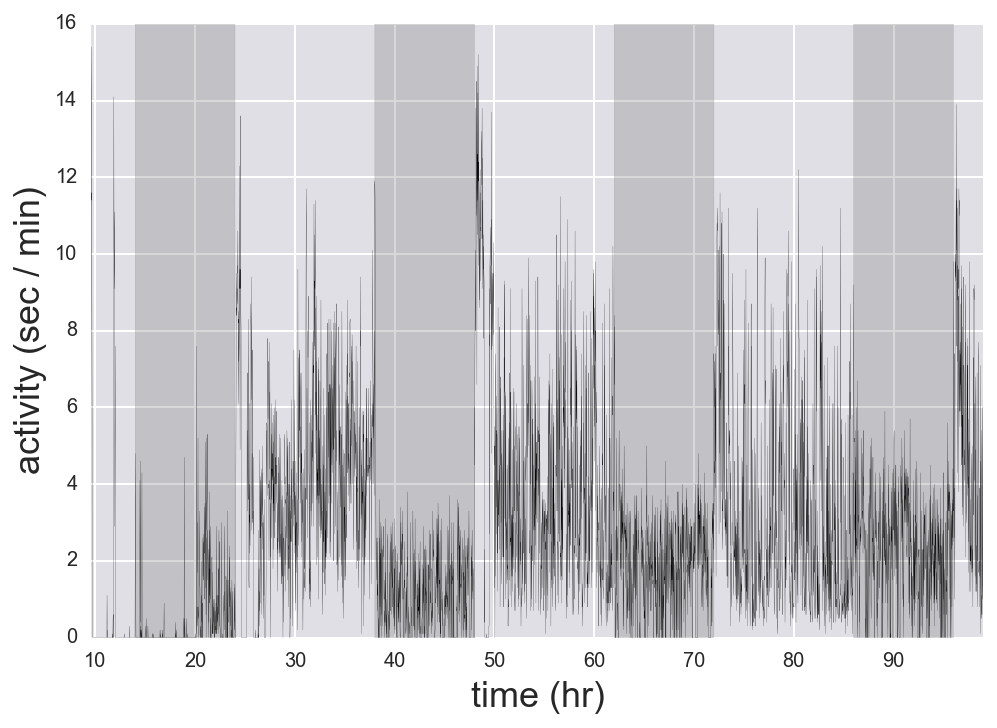

In [356]:
# Get view into DataFrame with only fish 1
df_fish1 = df_1[df_1['fish'] == 'FISH1']

# Get figure and axis objects using plt.subplots utility function
fig, ax = plt.subplots()

# Plot activity versus time for all fish.  lw denotes the line width
ax.plot(df_fish1.zeit, df_fish1.activity, 'k-', lw=0.1)
ax.set_xlabel('time (hr)')
ax.set_ylabel('activity (sec / min)')
ax.set_xlim((df_fish1.zeit.min(), df_fish1.zeit.max()))

# Get ylimits.  This is useful for fill_between.
ylims = ax.get_ylim()

# We can overlay day and night.  We'll make night shaded.
# The where keyword is useful, and ~df_wt.light means "not light."
ax.fill_between(df_fish1.zeit, ylims[0], ylims[1], where=~df_fish1.light, 
                color='gray',  alpha=0.3)

print('Fish 1 is', df_fish1.genotype.iloc[0])

Since we will want to make many plots like this, we can make a function to conveniently set the axis limits and put in the day/night shading.

In [357]:
def pretty_activity_plot(ax, fish, df, xlabel='time (hr)', 
                         ylabel='activity (sec / min)', show_night=True, lw=0.25, 
                         color=None):
    """
    Makes a pretty plot of sleep traces.  Generates the plot on axes ax,
    and then returns the updated ax.
    """
    # Pull out record of interest
    df_fish = df[df.fish==fish]
    
    # Generate plot
    if color is not None:
        ax.plot(df_fish.zeit, df_fish.activity, '-', lw=lw, color=color)
    else:
        ax.plot(df_fish.zeit, df_fish.activity, '-', lw=lw)

    # y_max is maximal y value encountered
    ax_y_max = ax.get_ylim()[1]
    y_max = max(ax_y_max, df_fish.activity.max())

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((df_fish.zeit.min(), df_fish.zeit.max()))
    ax.set_ylim((0.0, y_max))

    # We can overlay day and night if we haven't already.
    if show_night:
        ax.fill_between(df_fish.zeit, 0.0, y_max, where=~df_fish.light, 
                        color='gray', alpha=0.3, zorder=0)    

    return ax

We see decidedly more activity during the daylight time.  When looking at cumulative activity per minute, we see a lot of "noise" in the data.  This is not really noise, as zebrafish embryos tend to move in bursts when they are awake (as you can see in the Prober lab website).  The little fish may be moving and stopping, moving and stopping, etc., even though it is awake the whole time.  We will discuss at length the effects this has on our decisions regarding how to treat the data.  For now, we will following the example of the Prober, et al. paper.  There, the authors summed activity over 10-minute intervals.  We can do a similar summing to get activity over 10 minute intervals.  We can use the `pd.rolling_sum` function to do this.  The result is that entry `i` in a column of a DataFrame is given by the sum of elements `i-9` through `i`.

In [ ]:
# Perform the rolling sum and return it as a new DataFrame
time_win = 10  # in units of # of indices to sum over, equal to min here

# Compute the rolling sums for all wild type fish and return result
df_wt_win = pd.rolling_sum(df_wt, time_win)

# Plot the rolling summed data
fig, ax = plt.subplots()
ax = pretty_activity_plot(ax, df.zeit, df_wt_win.iloc[:,0], df, 
                          ylabel='activity (sec/10 min)')

This is a bit smoother, as we have averaged out some of the on/off nature of the larval movement.  However, the windows over which we summed overlap.  (This is an example of data smoothing, which we'll discuss later in the course.)  Prober, et al., report distinct ten minute intervals.  We can easily access these by slicing.

In [ ]:
# Define a new data frame that has results from the ten-minute windows
# Indexing time_win-1::time_win means start at index 9, 
# step till the end with step size 10 (here time_win = 10)
df_wt_10 = df_wt_win.iloc[time_win-1::time_win]

# Do rolling averages and slicing on het and mut DataFrames as well
df_het_10 = pd.rolling_sum(df_het, time_win).iloc[time_win-1::time_win]
df_mut_10 = pd.rolling_sum(df_mut, time_win).iloc[time_win-1::time_win]

There is a bit of a subtlety here, though.  As we have defined it, the time value corresponding to the 10-minute interval is the time of the 9th minute of the interval.  This is probably not the best definition.  But what should we use?  Do we use the start time?  The middle time?  The end time?  I didn't explicitly state it before, but we had been using the start time for our one-minute intervals up until now.  So, we will stick with that convention.

And there is more we should be careful of (though it won't affect our present analysis).  Because the indices of the activities and times no longer match to the same rows in the master raw DataFrame (`df`), we should re-index them.  (Bear in mind that this is different than applying the `pd.reindex` function.)

In [ ]:
# Reindex DataFrames with sequence of integers
df_wt_10.index = np.arange(len(df_wt_10))
df_het_10.index = np.arange(len(df_het_10))
df_mut_10.index = np.arange(len(df_mut_10))

# Time indices start from 0 and go in steps of 10 until the -9th index
df_addon = df[['zeit', 'light', 'day']].iloc[:-(time_win-1):10]

# Reindex the addon so that it matches indexing of the averaged DataFrames
df_addon.index = df_wt_10.index

# Change zeit, light, and day columns of DataFrames
df_wt_10[['zeit', 'light', 'day']] = df_addon
df_het_10[['zeit', 'light', 'day']] = df_addon
df_mut_10[['zeit', 'light', 'day']] = df_addon

We can now plot the results of our non-overlapping intervals.

In [ ]:
# Plot the results for non-overlapping ten minute intervals
fig, ax = plt.subplots()
ax = pretty_activity_plot(ax, df_wt_10.zeit, df_wt_10.iloc[:,0], df, lw=0.5, 
                          ylabel='activity (sec/10 min)')

## Saving the data to CSV files

Now that we have parsed the data into more readily usable formats, we would like to save them as CSV files so we can easily load them when we get back to work at a later time.  `pandas`'s `to_csv` method is a very convenient way to do this.

We will use descriptive file names to keep ourselves organized.

In [ ]:
# Save our new DataFrames to CSV files, using kwarg index=False to suppress
# writing of (trivial) indices
df_wt.to_csv('130315_wt.csv', index=False)
df_het.to_csv('130315_heterozygous_mutants.csv', index=False)
df_mut.to_csv('130315_homozygous_mutants.csv', index=False)
df_wt_10.to_csv('130315_wt_10_minute_intervals.csv', index=False)
df_het_10.to_csv('130315_heterozygous_mutants_10_minute_intervals.csv', 
                 index=False)
df_mut_10.to_csv('130315_homozygous_mutants_10_minute_intervals.csv', 
                 index=False)

Finally, I note that for time series data, as these activity data are, there are good arguments for using the time (in our case, the zeitgeber time, given by the `zeit` column) as the indices of the DataFrames.  It makes selecting specific time points more intuitive, for example.  Because our time points are not clean floats, this is a little less useful.  We will not do it here, but it is something to keep in mind as you think about how to organize your data in your own work.